Details for installing the necessary software are described on the Open Source Antbiotocs wiki here https://github.com/opensourceantibiotics/murligase/wiki/CompChem-Tools

# A Jupyter Notebook to aid Docking to Pf Carbonic Anhydrase protein


This notebook implements a typical protocol for docking ligands to a target protein. It uses RDKit (http://www.rdkit.org) to generate a number of reasonable conformations for each ligand and then uses SMINA (https://sourceforge.net/projects/smina/) to do the docking. Two methods of docking are implemented, the first docks into a rigid receptor, the second sets the protein side-chains around the active site to be flexible. Bear in mind flexible docking will be much, much slower. In the optional final step the resulting docked poses are rescored using a random forest model described in https://www.nature.com/articles/srep46710.

There is currently no crystal structure for PfηCA, this notebook uses an homology model generated from the crystal structure of a halotolerant carbonic anhydrase from Dunaliella salina (https://www.rcsb.org/structure/1y7w) which bears a little less than 20% identity. The homology model focusses on the active site and no attempt has been made to reconstruct the loop regions. More details here https://github.com/OpenSourceMalaria/Series3/issues/21

In [1]:
import sys
from collections import defaultdict
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
import pandas as pd
IPythonConsole.ipython_3d=True
%pylab inline

RDKit WARNING: [11:32:16] Enabling RDKit 2019.09.1 jupyter extensions


Populating the interactive namespace from numpy and matplotlib


## File location  of structures for docking and file format
First we need get the location of the input file of structures you want to dock, replace "asinexSelection.sdf" with your file. You may want to rename the output file for conformations, and the output file containing the docked structures.

The sdf file needs to have the name included in the first line of each molecule record.<br>

<code>AEM 10028511
  MOE2019           2D

 22 24  0  0  0  0  0  0  0  0999 V2000
    7.2040   -6.7290    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.3790   -6.7290    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0</code>

In [8]:
# File locations, needs full file path if not in same folder as the Jupyter notebook.
sdfFilePath = 'MyrandomSelection.sdf' # The input file of structures to generate conformations from
ConfoutputFilePath = 'ligandForDocking.sdf' # Output file containing conformations for docking

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

100

In [3]:
#Check that all molecules have a name
for i, mol in enumerate(inputMols):
    if mol is None:
        print('Warning: Failed to read molecule %s in %s' % (i, sdfFilePath))
    if not mol.GetProp('_Name'):

        print('Warning: No name for molecule %s in %s' % (i, sdfFilePath))

## Conformation generation
We next generate conformations, this uses paralellisation code from http://www.rdkit.org/docs/Cookbook.html contributed by Andrew Dalke. We don't use all cores on a desktop machine or it might be unresponsive. If running on a cluster you should modify this.

In [4]:
import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores -2

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time: 0:00:10 |################################|


In [5]:
ms = [x for x in Chem.SDMolSupplier(ConfoutputFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
for m in ms: Chem.AssignAtomChiralTagsFromStructure(m)
len(ms) # check how many conformations

482

## Docking to Protein
After generating the conformations we can now do the docking. In this example we use smina which can be downloaded from https://sourceforge.net/projects/smina/ you will need to know where smina has been installed, you may need to edit the --cpu term
The protein and ligand examples provided are from the homology model.

Docking using smina<br>
Need protein minus the ligand in pdb format, <br>
the ligand extracted from binding site in pdb format, <br>
Conformations to be docked as sdf from conformation generation above<br>
DockedFilePath = 'All_Docked.sdf.gz' is the File for the Docked structures

In [6]:
#you should edit the --cpu term to reflect the resources available on your machine.

ProteinForDocking = 'docked2minusLigand.pdb'
LigandFromProtein = 'ligandonly.pdb'
DockedFilePath = 'All_Docked.sdf.gz'
FlexibleDockedFilePath = 'FlexDocked.sdf.gz'

In [7]:
!'/usr/local/bin/smina.osx' --cpu 10 --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' -o '{DockedFilePath}'


   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity |

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.5       0.000      0.000    
2       -8.4       1.014      2.183    
3       -7.8       1.683      2.450    
4       -7.5       3.698      9.150    
5       -7.2       3.876      9.292    
6       -7.1       3.907      9.342    
7       -7.0       3.751      9.305    
8       -6.8       1.942      2.684    
9       -6.2       3.893      9.317    
Refine time 4.308
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.5  

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -9.1       0.000      0.000    
2       -8.9       3.609      6.060    
3       -8.2       3.421      6.547    
4       -7.9       3.512      5.915    
5       -7.6       3.379      6.013    
6       -7.5       2.092      5.297    
7       -7.5       3.496      5.844    
8       -7.3       4.318      7.262    
9       -7.2       4.173      5.941    
Refine time 8.416
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.9       0.000      0.000    
2       -7.6       2.988      4.928    
3       -7.5       2.106      3.176    
4       -7.2       3.60

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.7       0.000      0.000    
2       -7.6       2.101      2.724    
3       -7.2       1.245      1.953    
4       -6.7       2.305      2.881    
5       -6.4       2.485      3.019    
6       -6.3       2.245      6.908    
7       -6.1       2.613      2.964    
8       -5.9       3.611      4.270    
9       -5.9       3.755      8.212    
Refine time 3.813
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.5       0.000      0.000    
2       -7.4       2.098      2.595    
3       -6.7       2.069      2.550    
4       -6.3       1.74

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.2       0.000      0.000    
2       -7.2       3.375      10.039   
3       -7.1       4.749      7.994    
4       -7.1       2.244      2.887    
5       -7.0       3.056      4.748    
6       -7.0       4.178      6.081    
7       -7.0       3.104      9.055    
8       -6.9       3.157      10.167   
9       -6.9       3.188      3.826    
Refine time 13.299
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.3       0.000      0.000    
2       -7.1       3.348      5.975    
3       -7.1       3.314      4.381    
4       -7.0       4.2

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.5       0.000      0.000    
2       -7.3       2.622      3.887    
3       -6.9       4.153      4.771    
4       -6.8       2.398      2.843    
5       -6.7       3.387      4.424    
6       -6.6       4.438      8.963    
7       -6.4       3.795      8.965    
8       -6.3       2.530      8.354    
9       -5.9       4.292      5.825    
Refine time 8.232
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.5       0.000      0.000    
2       -7.3       2.592      3.756    
3       -6.9       3.616      4.639    
4       -6.9       4.21

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.3       0.000      0.000    
2       -8.2       4.409      5.958    
3       -6.6       5.176      7.234    
4       -6.3       5.130      7.468    
5       -6.3       4.729      6.697    
6       -6.3       3.770      6.492    
7       -6.2       5.137      6.431    
8       -6.2       2.691      3.540    
9       -6.1       4.889      7.739    
Refine time 10.700
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.4       0.000      0.000    
2       -8.4       4.382      6.062    
3       -6.9       5.039      7.114    
4       -6.6       3.7

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.1       0.000      0.000    
2       -7.0       2.387      4.101    
3       -6.9       0.981      1.985    
4       -6.6       1.941      3.032    
5       -6.2       2.209      3.521    
6       -6.0       3.463      6.000    
7       -5.9       2.567      4.019    
8       -5.9       2.493      5.345    
9       -5.8       2.847      5.689    
Refine time 5.909
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.2       0.000      0.000    
2       -6.9       0.991      1.989    
3       -6.7       0.907      1.998    
4       -6.6       1.34

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.4       0.000      0.000    
2       -8.2       2.721      7.126    
3       -8.2       2.824      4.815    
4       -8.2       3.557      7.392    
5       -8.0       2.954      5.124    
6       -7.9       3.275      5.302    
7       -7.7       3.875      6.583    
8       -7.6       4.255      6.576    
9       -7.6       3.621      6.039    
Refine time 25.388
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.2       0.000      0.000    
2       -7.9       3.571      7.217    
3       -7.8       3.320      5.370    
4       -7.6       4.2

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.1       0.000      0.000    
2       -8.1       3.694      8.493    
3       -7.9       2.561      7.863    
4       -7.9       2.510      8.232    
5       -7.8       2.907      8.605    
6       -7.7       2.463      3.721    
7       -7.6       2.144      3.198    
8       -7.6       2.145      2.867    
9       -7.6       3.253      8.407    
Refine time 9.812
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.1       0.000      0.000    
2       -8.1       3.629      8.473    
3       -7.9       2.751      8.247    
4       -7.9       3.07

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -9.2       0.000      0.000    
2       -8.9       2.544      3.139    
3       -8.7       2.154      6.064    
4       -8.6       2.560      5.475    
5       -8.5       2.844      5.900    
6       -8.4       2.156      5.693    
7       -8.4       2.513      6.012    
8       -8.3       2.215      6.147    
9       -8.3       2.604      5.582    
Refine time 25.019
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.4       0.000      0.000    
2       -7.8       2.836      6.892    
3       -7.8       4.680      8.727    
4       -7.6       3.8

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.5       0.000      0.000    
2       -8.5       0.508      2.162    
3       -8.2       1.968      2.619    
4       -8.1       1.979      2.539    
5       -8.1       2.273      3.090    
6       -8.0       2.929      3.343    
7       -7.9       2.160      3.058    
8       -7.8       2.501      3.140    
9       -7.8       2.089      2.620    
Refine time 18.590
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.8       0.000      0.000    
2       -8.7       0.522      2.181    
3       -8.4       2.150      3.092    
4       -8.3       2.0

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.9       0.000      0.000    
2       -7.9       1.127      1.581    
3       -7.7       3.210      7.165    
4       -7.6       2.697      3.743    
5       -7.5       2.084      7.676    
6       -7.3       2.579      3.894    
7       -7.2       1.743      7.509    
8       -7.2       2.722      5.302    
9       -7.1       3.335      5.994    
Refine time 16.460
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.7       0.000      0.000    
2       -7.4       1.173      1.959    
3       -7.2       3.519      4.719    
4       -6.9       3.0

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.5       0.000      0.000    
2       -8.3       1.941      2.682    
3       -7.9       2.137      4.848    
4       -7.9       2.033      2.248    
5       -7.8       2.705      3.457    
6       -7.7       2.177      2.510    
7       -7.6       2.847      6.623    
8       -7.5       3.584      6.843    
9       -7.1       2.514      3.351    
Refine time 10.989
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.4       0.000      0.000    
2       -8.3       2.145      3.122    
3       -8.3       3.191      4.667    
4       -8.2       2.8

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.6       0.000      0.000    
2       -8.1       2.568      7.133    
3       -7.8       4.036      5.990    
4       -7.5       3.879      5.484    
5       -7.5       3.813      7.808    
6       -7.4       4.552      8.313    
7       -7.1       5.239      7.177    
8       -6.8       3.512      5.147    
9       -6.8       4.188      5.882    
Refine time 10.915
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.6       0.000      0.000    
2       -7.9       4.036      5.988    
3       -7.5       3.767      7.768    
4       -7.1       4.3

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.6       0.000      0.000    
2       -7.5       5.207      9.389    
3       -7.5       5.357      9.258    
4       -7.5       5.987      9.943    
5       -7.4       4.007      5.631    
6       -7.1       5.156      9.257    
7       -7.0       3.426      4.583    
8       -6.9       4.184      5.246    
9       -6.4       5.110      6.902    
Refine time 11.776
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.6       0.000      0.000    
2       -8.3       2.350      2.761    
3       -7.9       5.420      10.452   
4       -7.5       2.7

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.7       0.000      0.000    
2       -7.7       2.312      4.227    
3       -7.6       2.693      4.943    
4       -7.3       1.494      2.492    
5       -7.2       1.834      2.497    
6       -7.2       3.650      9.544    
7       -7.1       2.943      4.667    
8       -7.1       2.557      9.239    
9       -7.1       2.216      3.962    
Refine time 26.513
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -9.0       0.000      0.000    
2       -8.6       1.703      2.645    
3       -8.6       2.195      2.954    
4       -8.5       1.9

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.9       0.000      0.000    
2       -7.7       3.195      9.557    
3       -7.4       1.606      2.881    
4       -7.0       3.760      7.354    
5       -6.8       3.151      9.610    
6       -6.7       3.736      8.339    
7       -6.7       3.946      10.038   
8       -6.7       3.479      9.277    
9       -6.5       2.148      2.524    
Refine time 15.654
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.0       0.000      0.000    
2       -7.9       3.337      9.867    
3       -7.5       3.258      9.550    
4       -7.4       1.9

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.8       0.000      0.000    
2       -7.4       1.978      2.930    
3       -7.4       1.885      3.001    
4       -7.4       2.993      4.724    
5       -7.3       2.182      3.483    
6       -7.1       3.756      5.609    
7       -7.1       3.527      8.857    
8       -7.0       2.261      3.047    
9       -6.8       2.110      3.360    
Refine time 19.498
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.8       0.000      0.000    
2       -7.6       1.916      2.994    
3       -7.5       3.008      4.931    
4       -7.4       2.1

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.9       0.000      0.000    
2       -7.6       2.417      3.502    
3       -7.4       1.024      1.787    
4       -7.4       2.744      4.053    
5       -7.3       1.784      2.351    
6       -7.3       1.270      2.691    
7       -7.2       2.326      3.396    
8       -7.1       2.178      3.011    
9       -7.0       1.830      2.390    
Refine time 5.315
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.9       0.000      0.000    
2       -7.6       2.458      3.508    
3       -7.4       2.735      4.063    
4       -7.4       0.95

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.7       0.000      0.000    
2       -8.7       0.048      1.011    
3       -8.1       4.594      9.026    
4       -7.9       2.995      3.601    
5       -7.5       1.726      2.580    
6       -7.4       1.873      2.142    
7       -7.4       4.618      9.329    
8       -7.2       4.568      9.730    
9       -7.1       3.963      4.497    
Refine time 7.424
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.2       0.000      0.000    
2       -8.0       0.821      1.696    
3       -7.8       2.784      3.642    
4       -7.4       2.46

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.9       0.000      0.000    
2       -7.8       2.054      6.167    
3       -7.7       3.482      5.003    
4       -7.6       3.834      7.340    
5       -7.5       3.235      6.456    
6       -7.4       2.890      3.677    
7       -7.4       4.592      6.323    
8       -7.2       3.427      4.034    
9       -7.1       3.738      5.908    
Refine time 8.797
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.2       0.000      0.000    
2       -8.2       2.058      6.191    
3       -8.0       4.151      7.248    
4       -7.9       4.65

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -9.8       0.000      0.000    
2       -9.6       3.643      4.866    
3       -9.0       2.389      3.022    
4       -8.7       3.552      4.467    
5       -8.1       2.919      3.940    
6       -8.0       3.406      5.633    
7       -8.0       2.833      9.751    
8       -8.0       1.488      2.010    
9       -7.7       2.733      3.231    
Refine time 18.587
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -9.2       0.000      0.000    
2       -8.5       3.922      4.934    
3       -8.3       3.497      4.594    
4       -8.1       2.3

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.4       0.000      0.000    
2       -7.4       2.166      5.233    
3       -7.1       2.232      2.961    
4       -7.1       2.308      5.385    
5       -7.0       2.370      5.327    
6       -6.9       1.911      2.516    
7       -6.8       1.731      2.455    
8       -6.6       3.162      4.449    
9       -6.4       3.101      4.215    
Refine time 6.498
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.1       0.000      0.000    
2       -7.0       2.259      5.290    
3       -6.7       1.598      2.383    
4       -6.5       2.73

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.5       0.000      0.000    
2       -8.3       2.582      4.240    
3       -8.1       1.718      2.059    
4       -7.6       3.135      3.927    
5       -7.5       2.589      3.053    
6       -7.3       2.921      4.681    
7       -7.2       2.245      2.630    
8       -7.2       3.528      10.269   
9       -7.1       4.243      6.267    
Refine time 13.798
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.4       0.000      0.000    
2       -8.2       2.608      3.881    
3       -8.1       2.173      6.481    
4       -8.0       2.8

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.5       0.000      0.000    
2       -6.8       2.154      5.695    
3       -6.6       2.024      2.271    
4       -6.5       2.460      3.069    
5       -6.2       1.877      2.442    
6       -5.9       2.455      5.212    
7       -5.9       2.306      6.761    
8       -5.8       3.109      4.528    
9       -5.8       1.998      6.377    
Refine time 5.933
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.4       0.000      0.000    
2       -6.6       1.944      2.144    
3       -6.5       2.466      3.076    
4       -6.4       2.24

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.6       0.000      0.000    
2       -8.6       5.248      8.645    
3       -8.5       5.250      8.622    
4       -8.3       5.285      8.560    
5       -8.0       4.456      8.300    
6       -7.9       4.163      8.243    
7       -7.8       2.675      7.617    
8       -7.8       1.949      2.555    
9       -7.4       6.029      9.090    
Refine time 9.853
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.7       0.000      0.000    
2       -8.6       5.267      8.689    
3       -8.6       5.227      8.644    
4       -8.4       5.36

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.4       0.000      0.000    
2       -7.4       2.387      3.908    
3       -7.0       3.350      9.062    
4       -6.8       2.692      9.522    
5       -6.3       4.051      8.460    
6       -6.2       2.139      2.588    
7       -6.2       1.795      1.950    
8       -6.2       2.858      3.792    
9       -6.2       2.730      3.745    
Refine time 13.673
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.6       0.000      0.000    
2       -7.5       2.374      3.881    
3       -6.8       2.676      9.526    
4       -6.7       4.0

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.9       0.000      0.000    
2       -8.8       2.123      3.521    
3       -8.7       1.594      2.130    
4       -8.5       1.559      2.055    
5       -8.3       2.405      3.416    
6       -8.1       3.311      8.318    
7       -8.1       2.864      9.298    
8       -7.9       1.651      2.197    
9       -7.8       2.805      9.649    
Refine time 21.389
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.7       0.000      0.000    
2       -8.5       2.108      2.970    
3       -8.3       3.704      9.451    
4       -8.2       2.8

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.0       0.000      0.000    
2       -7.9       1.480      2.203    
3       -7.7       2.419      3.596    
4       -7.7       1.695      2.308    
5       -7.1       2.434      3.452    
6       -7.0       2.636      3.830    
7       -7.0       3.136      8.860    
8       -7.0       2.501      3.279    
9       -6.9       3.889      9.612    
Refine time 10.293
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.9       0.000      0.000    
2       -7.9       1.360      2.125    
3       -7.8       1.709      2.280    
4       -7.7       2.2

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.6       0.000      0.000    
2       -7.6       0.210      2.641    
3       -7.5       2.583      8.786    
4       -7.2       3.387      7.690    
5       -7.2       3.326      7.578    
6       -7.2       2.616      8.600    
7       -6.8       2.694      8.629    
8       -6.8       3.090      8.671    
9       -6.7       3.114      8.737    
Refine time 11.369
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.6       0.000      0.000    
2       -7.6       0.200      2.805    
3       -7.4       2.632      8.776    
4       -7.3       3.3

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.9       0.000      0.000    
2       -8.2       2.000      2.539    
3       -8.2       4.057      5.440    
4       -8.1       3.528      5.354    
5       -8.0       4.084      6.065    
6       -7.8       4.041      5.931    
7       -7.8       2.172      2.437    
8       -7.8       3.693      6.077    
9       -7.7       3.847      5.800    
Refine time 13.602
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -9.2       0.000      0.000    
2       -9.1       2.017      2.930    
3       -9.0       4.393      5.726    
4       -9.0       3.2

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.1       0.000      0.000    
2       -7.1       3.194      6.251    
3       -6.9       1.667      2.078    
4       -6.9       3.445      6.050    
5       -6.7       3.171      5.891    
6       -6.5       2.903      6.153    
7       -6.5       4.484      5.709    
8       -6.5       3.879      7.178    
9       -6.5       4.153      6.178    
Refine time 7.226
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.0       0.000      0.000    
2       -7.2       3.195      6.507    
3       -7.2       3.110      6.413    
4       -7.1       3.37

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.5       0.000      0.000    
2       -7.7       2.028      4.712    
3       -7.7       3.082      4.440    
4       -7.5       1.932      2.482    
5       -7.4       3.648      8.097    
6       -7.2       2.448      4.598    
7       -7.1       2.998      7.985    
8       -7.0       3.533      8.090    
9       -6.9       2.229      4.067    
Refine time 12.602
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.9       0.000      0.000    
2       -8.8       2.352      3.492    
3       -8.3       2.744      7.813    
4       -8.2       2.1

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.0       0.000      0.000    
2       -6.9       1.154      2.069    
3       -6.9       3.420      10.324   
4       -6.8       3.535      10.200   
5       -6.8       3.509      10.183   
6       -6.6       4.139      10.324   
7       -6.5       3.427      10.449   
8       -6.5       3.335      4.696    
9       -6.4       3.071      3.951    
Refine time 15.106
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.1       0.000      0.000    
2       -8.1       2.050      3.551    
3       -8.0       1.840      2.840    
4       -7.7       2.9

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.3       0.000      0.000    
2       -7.1       2.569      3.269    
3       -6.9       3.601      6.027    
4       -6.7       2.592      4.351    
5       -6.5       2.766      7.594    
6       -6.2       1.495      1.830    
7       -6.1       2.807      7.386    
8       -6.1       2.298      3.929    
9       -6.1       2.786      7.297    
Refine time 9.138
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.7       0.000      0.000    
2       -7.6       2.078      3.605    
3       -7.4       2.525      3.366    
4       -7.3       2.66

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.4       0.000      0.000    
2       -7.2       1.978      2.716    
3       -7.1       3.980      8.264    
4       -7.0       1.502      2.235    
5       -6.9       4.265      8.118    
6       -6.8       1.148      1.362    
7       -6.8       3.956      8.329    
8       -6.4       4.675      7.993    
9       -6.4       2.887      3.574    
Refine time 10.880
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.4       0.000      0.000    
2       -7.3       1.996      2.757    
3       -7.2       4.429      8.148    
4       -7.2       4.0

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.8       0.000      0.000    
2       -8.6       2.866      3.775    
3       -8.6       3.118      7.682    
4       -8.6       1.893      2.126    
5       -8.3       3.603      8.955    
6       -8.1       2.074      2.603    
7       -8.0       2.323      2.871    
8       -8.0       3.830      8.982    
9       -7.9       3.518      6.964    
Refine time 17.096
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.8       0.000      0.000    
2       -8.7       1.782      2.496    
3       -8.6       3.173      7.737    
4       -8.4       2.8

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.0       0.000      0.000    
2       -8.0       3.423      8.921    
3       -7.9       1.870      2.218    
4       -7.8       2.780      5.402    
5       -7.6       3.866      5.735    
6       -7.5       3.017      7.834    
7       -7.5       3.590      5.837    
8       -7.4       3.179      6.556    
9       -7.3       3.171      5.573    
Refine time 22.328
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -8.8       0.000      0.000    
2       -8.7       2.186      3.824    
3       -8.5       3.735      9.104    
4       -8.2       2.5

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -9.9       0.000      0.000    
2       -9.8       3.996      5.594    
3       -9.7       1.566      2.083    
4       -9.6       2.652      4.758    
5       -9.6       1.676      2.240    
6       -9.4       1.626      2.081    
7       -9.3       3.249      4.722    
8       -9.3       1.957      3.102    
9       -9.2       2.272      3.465    
Refine time 22.583
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -9.3       0.000      0.000    
2       -9.1       2.559      3.153    
3       -8.9       0.833      1.542    
4       -8.7       3.8

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.2       0.000      0.000    
2       -7.1       3.186      6.719    
3       -6.6       2.728      5.466    
4       -6.6       2.440      3.953    
5       -6.5       1.287      1.521    
6       -6.5       3.597      7.070    
7       -6.4       1.777      2.815    
8       -6.3       3.286      5.442    
9       -6.2       1.961      2.772    
Refine time 14.639
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.3       0.000      0.000    
2       -7.2       3.320      7.288    
3       -6.7       1.793      2.781    
4       -6.4       3.1

Flexible docking method, set all side chains within specified distance to flexdist_ligand to flexible
This will take an order of magnitude longer. You will need to assign the flexible residues by modifying the "--flexres A:124,A:132".
Currently disabled, to enable remove the #

In [9]:
#you need to define amino acids that can move, probably need a more refined structure.
#!'/usr/local/bin/smina.osx' --cpu 10 --seed 0 --autobox_ligand '{LigandFromProtein}'  --autobox_add 5 -r '{ProteinForDocking}' --flexres A:124,A:132,A:143,A:147,A:311,A:312,A:434,A:435 -l '{ConfoutputFilePath}' -o '{FlexibleDockedFilePath}'



## Rescoring using Random Forest Model

Optional, 
Rescore using a random forest model described in https://www.nature.com/articles/srep46710

Download from https://github.com/oddt/rfscorevs
You will need the path to the binary

Path to protein containing ligand in pdb format<br>
protein_plus_ligand<br>
File to store rescored results

In [10]:


TargetProtein = 'docked2.pdb'
scoreResults = 'DockedRescored.csv'

In [11]:
!/usr/local/bin/rf-score-vs --receptor '{TargetProtein}' '{DockedFilePath}' -o csv -O '{scoreResults}' --field name --field RFScoreVS_v2

In [12]:

docked_df = PandasTools.LoadSDF(DockedFilePath,molColName='Molecule', removeHs=False)


minimizedAffinity            ID  \
0          -8.41578  CHEMBL171350   
1          -8.38074  CHEMBL171350   
2          -7.89339  CHEMBL171350   
3          -7.77434  CHEMBL171350   
4          -7.63414  CHEMBL171350   

                                            Molecule  
0  <img data-content="rdkit/molecule" src="data:i...  
1  <img data-content="rdkit/molecule" src="data:i...  
2  <img data-content="rdkit/molecule" src="data:i...  
3  <img data-content="rdkit/molecule" src="data:i...  
4  <img data-content="rdkit/molecule" src="data:i...
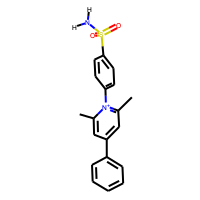
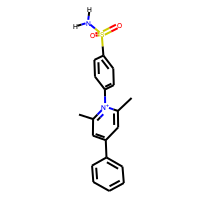
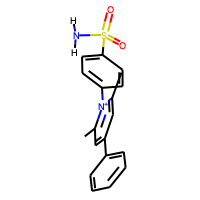
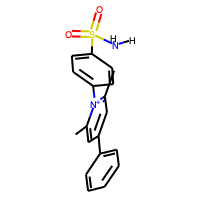
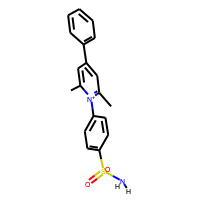

In [13]:
docked_df.head(n=5)

In [14]:
scores_df = pd.read_csv(scoreResults)

In [15]:
#scores_df.head(n=5)



In [16]:
results_df = pd.concat([docked_df, scores_df], axis=1)

minimizedAffinity            ID  \
0          -8.41578  CHEMBL171350   
1          -8.38074  CHEMBL171350   
2          -7.89339  CHEMBL171350   
3          -7.77434  CHEMBL171350   
4          -7.63414  CHEMBL171350   

                                            Molecule          name  \
0  <img data-content="rdkit/molecule" src="data:i...  CHEMBL171350   
1  <img data-content="rdkit/molecule" src="data:i...  CHEMBL171350   
2  <img data-content="rdkit/molecule" src="data:i...  CHEMBL171350   
3  <img data-content="rdkit/molecule" src="data:i...  CHEMBL171350   
4  <img data-content="rdkit/molecule" src="data:i...  CHEMBL171350   

   RFScoreVS_v2  
0      6.076956  
1      6.080074  
2      6.039329  
3      6.038853  
4      6.016157
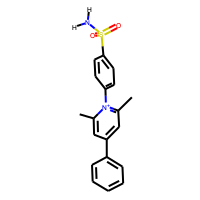
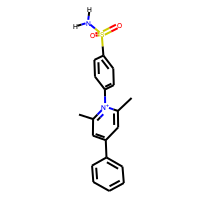
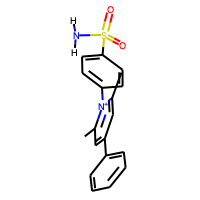
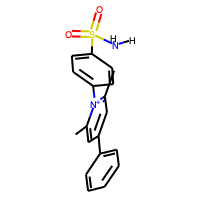
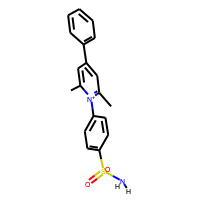

In [17]:
results_df.head(5)

## Saving the results
Now combine rescored file with docked structure file and export to "Alldata.sdf.gz" this is a big file so export compressed

In [18]:
combinedResults = 'Alldata.sdf.gz'

In [19]:
PandasTools.WriteSDF(results_df, combinedResults, molColName="Molecule", idName="ID", properties=list(results_df.columns))